In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

In [2]:
# Read unemployment data
unemp = pd.read_csv('DC2Data/unemployment.csv')
unemp = unemp.dropna()

pattern = r'^\d{4}\s[A-Z]{3}$'

# # Filter the DataFrame using the regular expression pattern
unemp = unemp[unemp['Title'].str.contains(pattern)]
unemp['Title'] = pd.to_datetime(unemp['Title'], format='%Y %b')
unemp.columns = ['ds', 'Unemployment']
# unemp = unemp.set_index('Date')
unemp["Unemployment"] = unemp["Unemployment"].astype(float)
unemp['change'] = unemp['Unemployment'].diff()
unemp = unemp.dropna()

In [3]:
# Read inflation data
inflation = pd.read_csv('DC2Data/inflation.csv')
inflation = inflation.dropna()

pattern = r'^\d{4}\s[A-Z]{3}$'

# # Filter the DataFrame using the regular expression pattern
inflation = inflation[inflation['Title'].str.contains(pattern)]

inflation.columns = ['ds', 'Inflation']
inflation['ds'] = pd.to_datetime(inflation['ds'], format='%Y %b')
# inflation = inflation.set_index('Date')
inflation["Inflation"] = inflation["Inflation"].astype(float)
inflation['change'] = inflation['Inflation'].diff()
inflation = inflation.dropna()
inflation

,ds,Inflation,change
179,1989-02-01,5.8,0.1
180,1989-03-01,5.9,0.1
181,1989-04-01,5.6,-0.3
182,1989-05-01,5.9,0.3
183,1989-06-01,5.8,-0.1
...,...,...,...
585,2022-12-01,9.2,-0.1
586,2023-01-01,8.8,-0.4
587,2023-02-01,9.2,0.4
588,2023-03-01,8.9,-0.3


In [4]:
# Read GDP data
gdp = pd.read_csv('DC2Data/GDPMonthly.csv')
gdp.columns = ['ds', 'GDP']
gdp.dropna(inplace=True)

# Function to check if a value is a valid date in the format 'MMM YYYY'
def is_valid_date(date_str):
    try:
        datetime.strptime(date_str, '%b %Y')
        return True
    except ValueError:
        return False

# Filter dataframe to include only rows with valid dates in the 'ds' column
gdp = gdp[gdp['ds'].apply(is_valid_date)]
gdp['ds'] = pd.to_datetime(gdp['ds'], format='%b %Y')
gdp['GDP'] = gdp['GDP'].astype(float)
gdp['change'] = gdp['GDP'].diff()
gdp = gdp.dropna()


In [5]:
merged = pd.merge(unemp, inflation, on='ds')
merged = pd.merge(merged, gdp, on='ds')
merged.columns = ['ds', 'Unemployment', 'UnemploymentChange', 'Inflation', 'InflationChange', 'GDP', 'GDPChange']
merged

,ds,Unemployment,UnemploymentChange,Inflation,InflationChange,GDP,GDPChange
0,2007-02-01,5.5,0.0,2.7,0.0,84.6,0.6
1,2007-03-01,5.5,0.0,2.9,0.2,84.9,0.3
2,2007-04-01,5.4,-0.1,2.7,-0.2,84.9,0.0
3,2007-05-01,5.4,0.0,2.5,-0.2,85.0,0.1
4,2007-06-01,5.3,-0.1,2.5,0.0,85.0,0.0
...,...,...,...,...,...,...,...
188,2022-10-01,3.7,0.0,9.6,0.8,100.4,0.7
189,2022-11-01,3.7,0.0,9.3,-0.3,100.5,0.1
190,2022-12-01,3.7,0.0,9.2,-0.1,100.0,-0.5
191,2023-01-01,3.8,0.1,8.8,-0.4,100.5,0.5


In [29]:
# read the crime data
crime = pd.read_csv('DC2Data/wards_crime_covid_adjusted_filled_rnd_gaps.csv')
crime["ds"] = pd.to_datetime(crime["ds"], format='%Y-%m-%d')
# limit the data to everything before 2020
# test_set = merged[merged['ds'] >= '2020-01-01']
# crime = crime[crime['ds'] < '2020-01-01']
crime = crime.set_index('ds')

In [32]:
scores_with =[]
scores_without = []

for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')

    train_set = merg[merg['ds'] < '2020-01-01']
    test_set = merg[merg['ds'] >= '2020-01-01']
    merg.set_index('ds')
    merg.dropna(inplace=True)
    # Linear regression on y
    X = train_set[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = train_set['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    score_with = model.rsquared
    scores_with.append(score_with)
    # print(f"{group} with GDP: {score_with}")
    X = train_set[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange']]
    y = train_set['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    score_without = model.rsquared
    scores_without.append(score_without)
    # print("Ward " + str(group) + " with GDP: " + str(score_with) + " without GDP: " + str(score_without))
    # print("Difference: " + str(score_with - score_without))

    X = test_set[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = test_set['trend']
    X = sm.add_constant(X)
    predictions = model.predict(X)
    test_set['predictions'] = predictions
    test_set.plot(y=['y', 'predictions'], title=group)
    plt.show()

    # predictions = model.predict(X)
    # merg['predictions'] = predictions




# print("Average score with GDP: " + str(sum(scores_with)/len(scores_with)))
# print("Average score without GDP: " + str(sum(scores_without)/len(scores_without)))
# print("\n")
# print("Median score with GDP: " + str(sorted(scores_with)[len(scores_with)//2]))
# print("Median score without GDP: " + str(sorted(scores_without)[len(scores_without)//2]))
# print("\n")
# print("Max score with GDP: " + str(max(scores_with)))
# print("Max score without GDP: " + str(max(scores_without)))
# print("\n")
# print("Min score with GDP: " + str(min(scores_with)))
# print("Min score without GDP: " + str(min(scores_without)))

     const  Unemployment  UnemploymentChange  Inflation  InflationChange   
109    1.0           4.0                 0.1        1.8              0.4  \
110    1.0           4.0                 0.0        1.7             -0.1   
111    1.0           4.1                 0.1        1.5             -0.2   
112    1.0           4.1                 0.0        0.9             -0.6   
113    1.0           4.1                 0.0        0.7             -0.2   
114    1.0           4.3                 0.2        0.8              0.1   
115    1.0           4.6                 0.3        1.1              0.3   
116    1.0           4.9                 0.3        0.5             -0.6   
117    1.0           5.1                 0.2        0.7              0.2   
118    1.0           5.1                 0.0        0.9              0.2   
119    1.0           5.2                 0.1        0.6             -0.3   
120    1.0           5.1                -0.1        0.8              0.2   
121    1.0  

ValueError: shapes (38,7) and (5,) not aligned: 7 (dim 1) != 5 (dim 0)

109    19.173263
110    18.340277
111    15.466487
112     4.996760
113     1.599915
114     6.272333
115    11.879811
116    14.558427
117    17.352939
118    17.688243
119    16.941616
120    17.505591
121    16.478912
122    15.035200
123    16.557911
124    18.279501
125    18.265312
126    18.037312
127    16.878229
128    17.903606
129    16.498844
130    17.101783
131    16.278118
132    15.410005
133    14.584339
134    14.450453
135    14.280797
136    14.250989
137    12.076275
138    11.296038
139    10.786946
140    10.113525
dtype: float64


C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


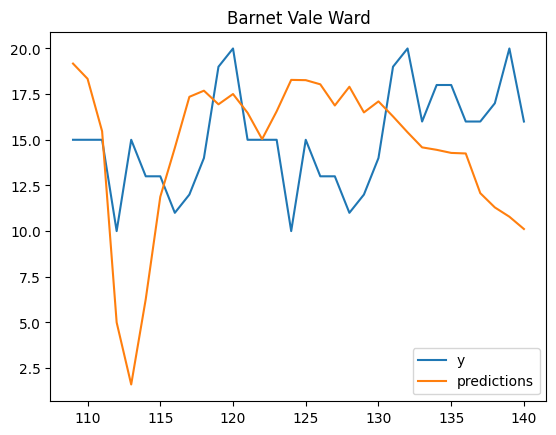

109    15.841066
110    16.217869
111    16.978362
112    21.261375
113    25.458234
114    23.533949
115    20.920801
116    19.307758
117    18.611380
118    18.791081
119    18.760171
120    19.213055
121    19.053495
122    20.103515
123    19.212207
124    18.492848
125    18.320394
126    17.943700
127    18.070097
128    17.653267
129    17.816161
130    17.607324
131    17.882103
132    17.801705
133    18.257826
134    18.072238
135    17.955863
136    18.442006
137    19.096488
138    19.456374
139    19.548329
140    19.331644
dtype: float64


C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


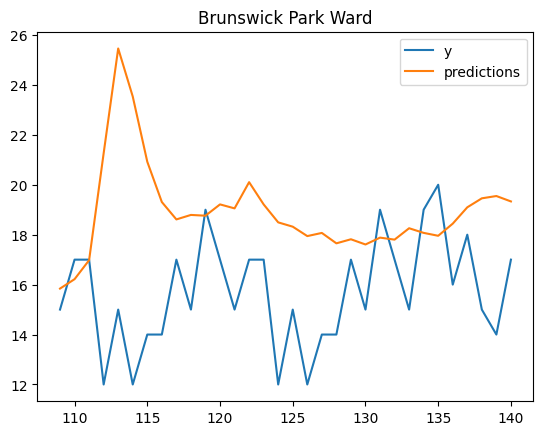

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    19.102139
110    18.615696
111    14.576421
112     3.314660
113     1.251064
114     5.203475
115    10.207497
116    12.096859
117    15.295646
118    16.643251
119    15.017540
120    16.982940
121    15.186813
122    15.021715
123    15.833157
124    17.871902
125    19.079713
126    18.535107
127    17.827656
128    18.932880
129    17.483871
130    18.536143
131    18.114163
132    16.705137
133    17.071388
134    16.763979
135    15.767219
136    16.807056
137    14.566399
138    14.952615
139    14.347814
140    12.436410
dtype: float64


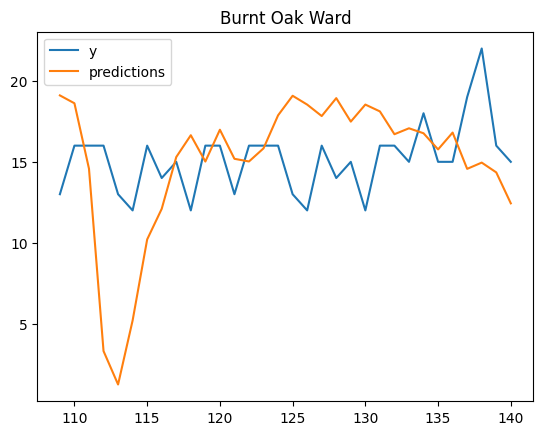

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    22.460516
110    23.284708
111    29.923996
112    48.667002
113    51.640732
114    45.001336
115    37.058341
116    34.005349
117    29.502258
118    27.718196
119    30.139106
120    27.316533
121    30.148705
122    30.377176
123    28.836082
124    25.650718
125    23.905720
126    24.465829
127    25.378453
128    23.770314
129    25.678559
130    24.315554
131    24.939283
132    26.892258
133    26.433973
134    26.889332
135    28.362705
136    27.367374
137    30.510337
138    30.190043
139    31.026881
140    33.588404
dtype: float64


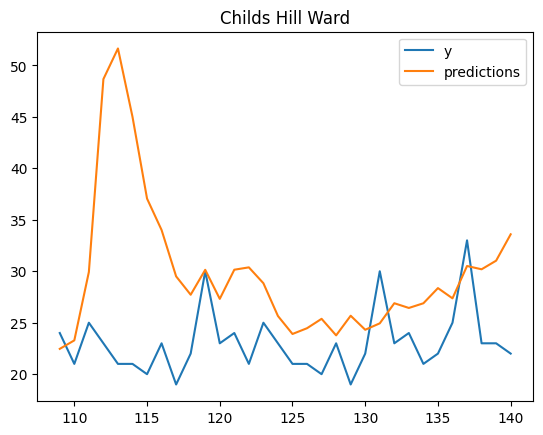

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    10.912278
110    10.462602
111    10.369833
112    10.306474
113    11.429805
114    11.601392
115    11.485851
116    10.576344
117    11.275075
118    11.240570
119    10.780496
120    11.334967
121    11.109164
122    11.023738
123    11.365013
124    11.433552
125    11.153282
126    10.805624
127    10.296542
128    11.197341
129    10.216481
130    10.919705
131    10.588161
132     9.875624
133     9.802216
134    10.084790
135     9.924721
136    10.365805
137     8.859472
138     8.993852
139     9.115615
140     8.314739
dtype: float64


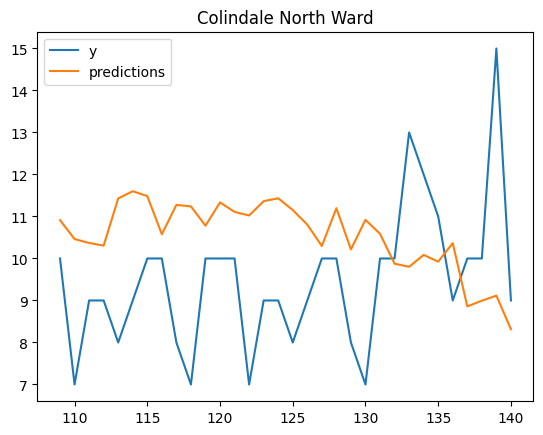

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    11.278950
110    10.884553
111    10.586821
112     9.097902
113     9.141198
114    10.007800
115    10.774380
116    10.631465
117    11.095627
118    10.910371
119    10.724960
120    10.784151
121    10.716332
122    10.255241
123    10.853314
124    11.187158
125    10.933253
126    10.968193
127    10.482209
128    11.205327
129    10.690663
130    11.169290
131    11.115891
132    10.929211
133    10.586623
134    10.904966
135    11.206316
136    11.529089
137    10.784733
138    10.550001
139    10.775791
140    10.629391
dtype: float64


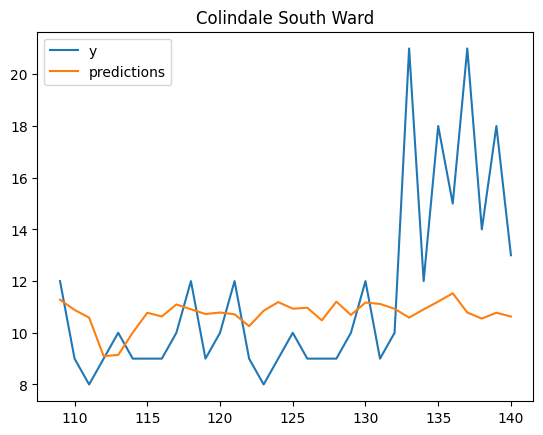

109    10.721109
110    11.011985
111    11.748088
112    12.658656
113    12.386760
114    12.456012
115    12.343483
116    13.209440
117    11.867409
118    11.204976
119    12.188546
120    10.850700
121    11.434071
122    11.041683
123    11.082442
124    10.731591
125    10.169102
126    10.778384
127    11.039059
128    10.052007
129    11.255202
130    10.199306
131    10.524597
132    11.696160
133    11.099207
134    10.958030
135    11.779649
136    10.791574
137    12.757027
138    11.859752
139    11.981535
140    13.673218
dtype: float64


C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


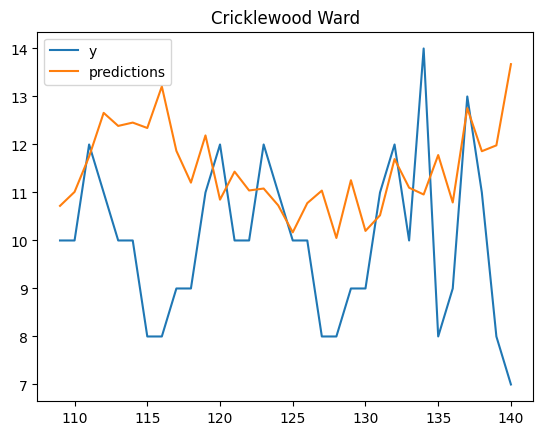

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    16.954576
110    17.767162
111    17.400268
112    15.053295
113    11.314127
114    12.302348
115    14.350619
116    17.796568
117    17.401759
118    17.605396
119    18.586947
120    17.451765
121    17.585044
122    17.268733
123    16.695811
124    16.718781
125    16.962007
126    17.268397
127    18.003496
128    15.761441
129    17.302629
130    15.437560
131    15.289950
132    16.334985
133    16.088836
134    14.962789
135    14.822018
136    13.078084
137    15.440285
138    14.709066
139    13.764358
140    15.306470
dtype: float64


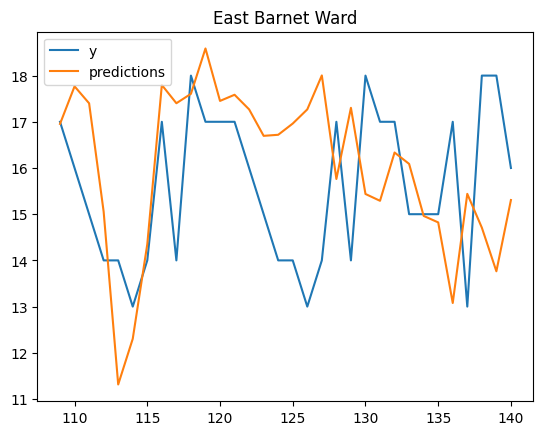

109    15.592431
110    16.140407
111    16.584532
112    17.854070
113    17.512261
114    17.002286
115    16.631915
116    17.628233
117    16.831314
118    16.800470
119    17.443436
120    16.817305
121    17.007052
122    17.234299
123    16.607458
124    16.135229
125    16.051241
126    16.143688
127    16.683678
128    15.302162
129    16.272232
130    15.124862
131    15.101205
132    15.703953
133    15.700874
134    15.098463
135    15.001623
136    13.987207
137    15.519621
138    15.226978
139    14.822179
140    15.708905
dtype: float64


C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


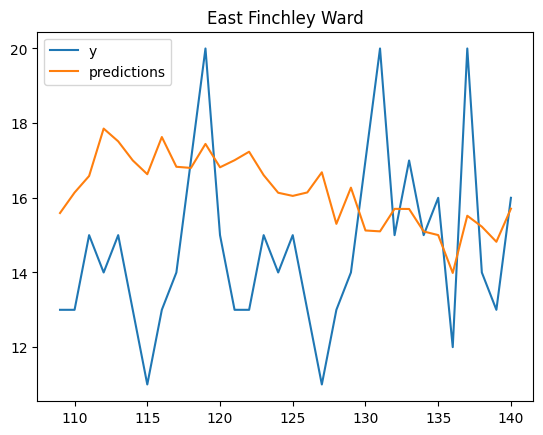

109    19.608829
110    19.868995
111    19.982858
112    17.942908
113    12.056308
114    13.010729
115    15.527413
116    17.878256
117    18.260160
118    18.504480
119    19.030558
120    18.033825
121    18.741369
122    17.519167
123    17.729876
124    18.498704
125    19.221608
126    19.821716
127    19.861298
128    19.607366
129    20.249850
130    20.244544
131    20.746123
132    21.659081
133    21.314274
134    21.400178
135    22.159862
136    22.671145
137    23.731375
138    23.541283
139    23.473542
140    24.314615
dtype: float64


C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


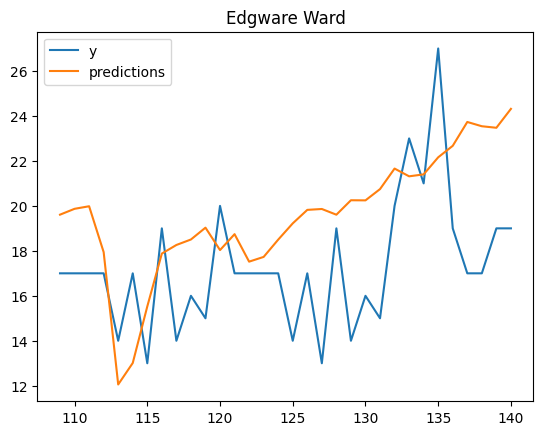

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    12.909488
110    12.869088
111    14.743512
112    19.492377
113    19.546599
114    18.017581
115    16.287749
116    15.270408
117    14.474789
118    13.952661
119    14.457654
120    13.733682
121    14.628761
122    14.282384
123    14.218720
124    13.604487
125    13.134804
126    13.308113
127    13.228004
128    13.452549
129    13.526446
130    13.720277
131    13.912523
132    14.288162
133    14.010959
134    14.474221
135    15.100335
136    15.367816
137    15.546630
138    15.509894
139    15.934447
140    16.375567
dtype: float64


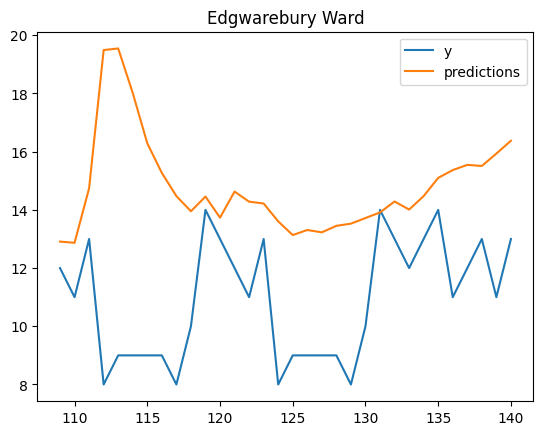

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    15.345326
110    16.111881
111    20.808029
112    34.423601
113    35.231704
114    30.203554
115    24.669492
116    23.270010
117    20.596674
118    19.696686
119    21.357944
120    19.648464
121    21.463081
122    21.901579
123    20.262080
124    17.687597
125    16.611800
126    16.493593
127    17.479751
128    15.667872
129    16.796045
130    15.390470
131    15.043529
132    15.879784
133    15.864198
134    15.578667
135    15.561494
136    13.961854
137    15.559893
138    15.637188
139    15.462742
140    16.760903
dtype: float64


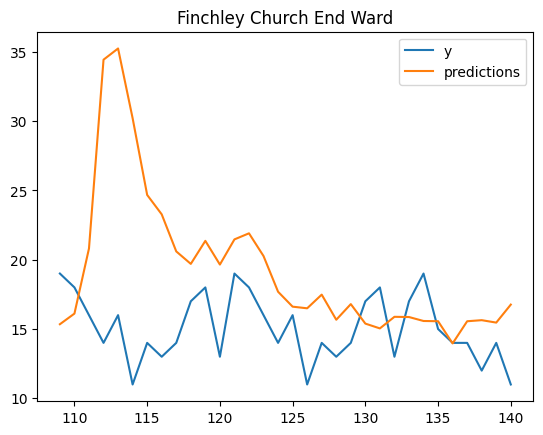

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    17.463761
110    17.226497
111    17.235760
112    16.633273
113    16.442380
114    16.992109
115    17.744056
116    17.737262
117    18.367756
118    18.396514
119    18.281613
120    18.318333
121    18.350767
122    17.809976
123    18.166368
124    18.523488
125    18.375216
126    18.321144
127    17.717831
128    18.340088
129    17.831918
130    18.360856
131    18.467546
132    18.367807
133    18.036877
134    18.309365
135    18.776130
136    19.609168
137    19.120635
138    18.966663
139    19.157699
140    19.008700
dtype: float64


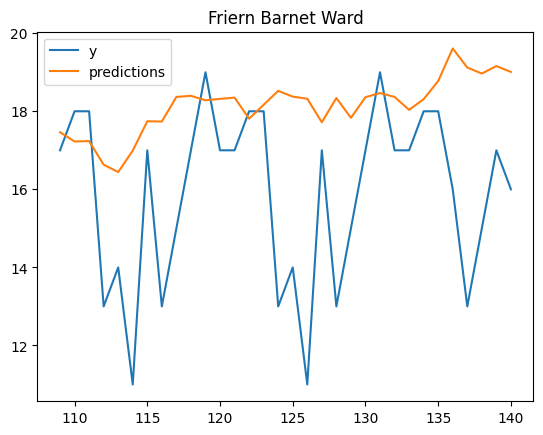

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    19.370583
110    19.855098
111    21.569242
112    26.533101
113    28.994713
114    27.368789
115    24.878924
116    24.426565
117    22.236780
118    21.403967
119    22.536480
120    21.264748
121    21.960229
122    22.284793
123    21.735536
124    20.555031
125    19.642990
126    20.034262
127    20.557531
128    19.199179
129    20.565799
130    19.211521
131    19.494529
132    20.614676
133    20.274078
134    20.036596
135    20.647533
136    19.399388
137    21.658494
138    20.958944
139    21.131338
140    22.808274
dtype: float64


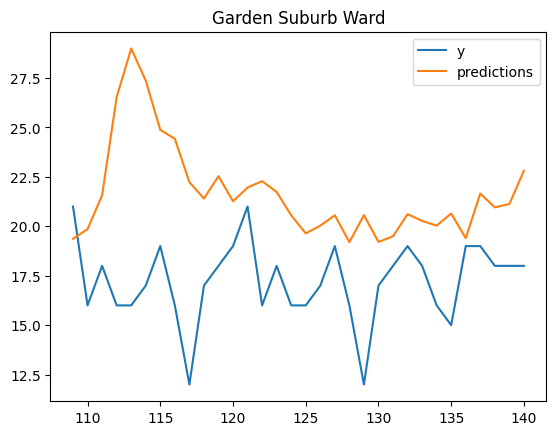

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    14.526029
110    13.820481
111    13.094097
112     7.468749
113     1.792088
114     4.671066
115     8.785414
116    10.580939
117    12.068910
118    11.912936
119    11.858125
120    11.200245
121    11.653522
122     9.542160
123    11.134396
124    12.645712
125    12.870774
126    13.497033
127    12.518465
128    14.035801
129    13.381139
130    14.566524
131    14.835722
132    15.126201
133    14.145561
134    14.978681
135    16.182583
136    17.321888
137    16.345774
138    15.779199
139    16.207653
140    16.462205
dtype: float64


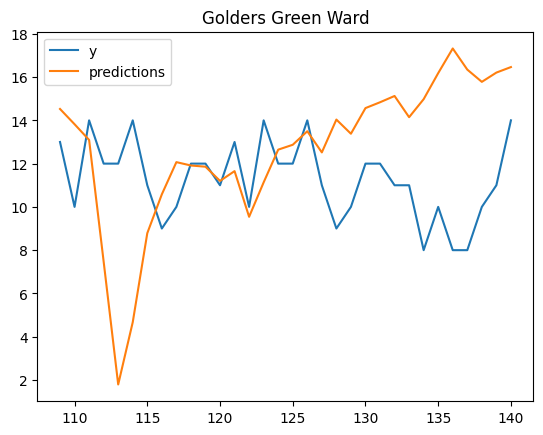

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    27.995313
110    27.379692
111    27.153466
112    21.740213
113    15.073322
114    18.266781
115    22.677341
116    25.404821
117    26.219232
118    25.545793
119    26.182554
120    24.554601
121    25.419879
122    22.850388
123    24.575906
124    25.814451
125    25.533861
126    26.482008
127    25.655614
128    26.486306
129    26.452170
130    26.858738
131    27.002191
132    27.913853
133    26.413105
134    27.070355
135    28.617601
136    28.668100
137    28.574308
138    27.314739
139    27.641622
140    28.972259
dtype: float64


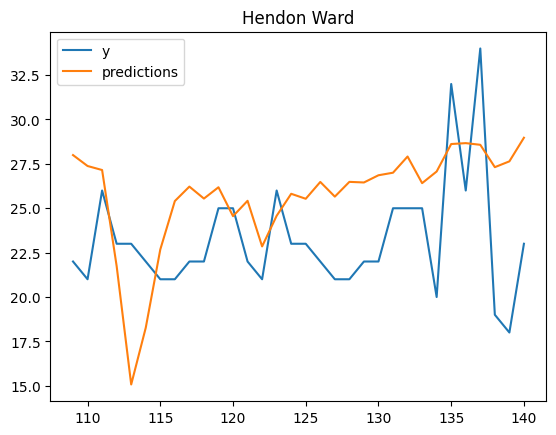

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    16.176427
110    16.729504
111    17.502895
112    17.834156
113    12.205798
114    12.040496
115    13.393803
116    15.396289
117    15.136778
118    15.396396
119    16.145116
120    14.970705
121    15.945253
122    15.062063
123    14.811559
124    15.202531
125    16.062552
126    16.731233
127    17.136993
128    16.474328
129    17.569133
130    17.328722
131    18.045170
132    19.231638
133    19.135242
134    19.168742
135    19.921694
136    20.410621
137    22.162271
138    22.198297
139    22.164568
140    23.212821
dtype: float64


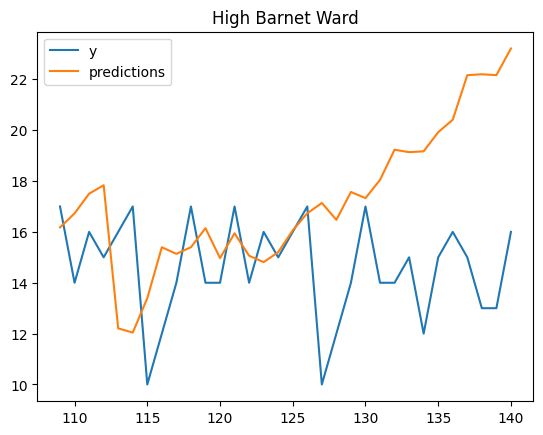

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    15.692444
110    15.549628
111    16.463799
112    17.381341
113    16.137873
114    16.382080
115    16.788068
116    17.161468
117    16.907148
118    16.401772
119    16.957380
120    16.018509
121    16.682101
122    15.746229
123    16.175759
124    16.178336
125    15.668680
126    16.017721
127    15.640008
128    15.812391
129    15.938666
130    15.962172
131    16.144750
132    16.718704
133    16.008353
134    16.339197
135    17.260454
136    17.376914
137    17.756614
138    17.162579
139    17.460808
140    18.291255
dtype: float64


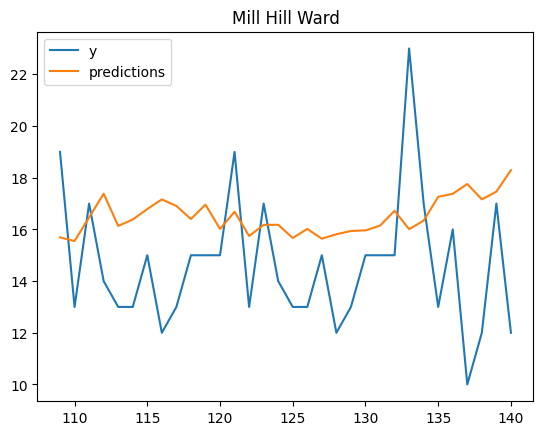

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    16.946110
110    17.172541
111    18.740443
112    23.994380
113    26.355215
114    24.222885
115    21.472390
116    19.604520
117    18.184569
118    17.844460
119    18.189827
120    17.801237
121    18.455831
122    18.855310
123    18.469785
124    17.849037
125    17.706878
126    18.023766
127    18.196700
128    18.301592
129    18.867495
130    19.039314
131    19.870930
132    20.497638
133    20.653235
134    21.155203
135    21.928997
136    22.759140
137    23.888029
138    24.121046
139    24.845570
140    25.320139
dtype: float64


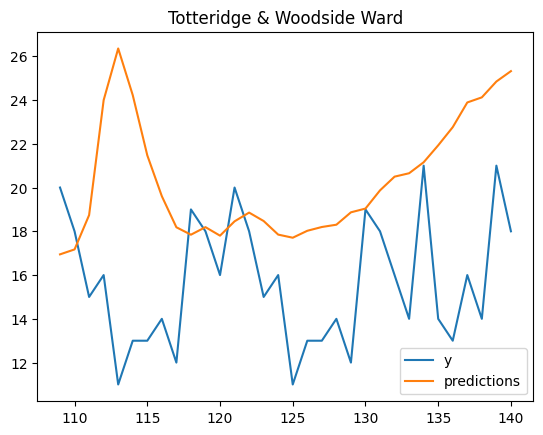

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    10.810672
110    10.635812
111    11.310882
112    12.345262
113    11.580706
114    11.396475
115    11.292704
116    10.804264
117    10.571826
118    10.293112
119    10.449084
120    10.000093
121    10.558244
122     9.986586
123    10.386620
124    10.570258
125    10.543252
126    10.936629
127    10.653405
128    11.349544
129    11.354243
130    11.946940
131    12.475467
132    12.885112
133    12.604090
134    13.233390
135    14.095772
136    14.982621
137    15.119465
138    15.061512
139    15.644251
140    15.951587
dtype: float64


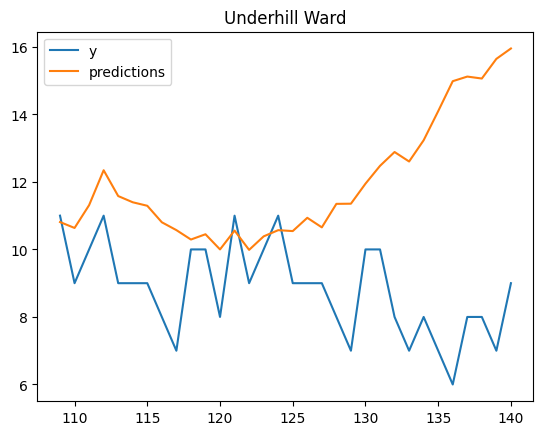

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    20.192084
110    20.558017
111    22.983916
112    29.159001
113    28.708369
114    26.717270
115    24.648979
116    24.614139
117    23.289868
118    22.679233
119    23.776022
120    22.497268
121    23.562448
122    23.344468
123    22.716688
124    21.522521
125    20.779102
126    20.857879
127    21.216317
128    20.162851
129    20.862446
130    19.958640
131    19.769031
132    20.453044
133    20.094179
134    19.917665
135    20.211952
136    19.205053
137    20.287036
138    19.943125
139    19.823337
140    20.922897
dtype: float64


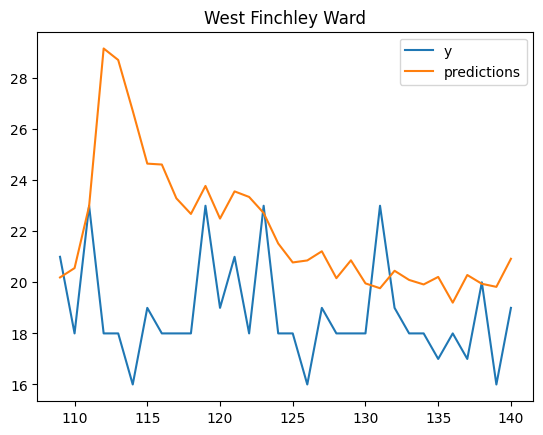

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    17.561909
110    17.140246
111    16.514561
112    14.883600
113    15.725483
114    16.453167
115    17.015958
116    16.527400
117    17.391687
118    17.478415
119    16.941834
120    17.572860
121    17.163282
122    17.061725
123    17.486328
124    17.815692
125    17.696697
126    17.411649
127    16.903715
128    17.748215
129    16.860255
130    17.511519
131    17.258030
132    16.596681
133    16.534699
134    16.738259
135    16.583389
136    17.050617
137    15.713194
138    15.785812
139    15.858420
140    15.095676
dtype: float64


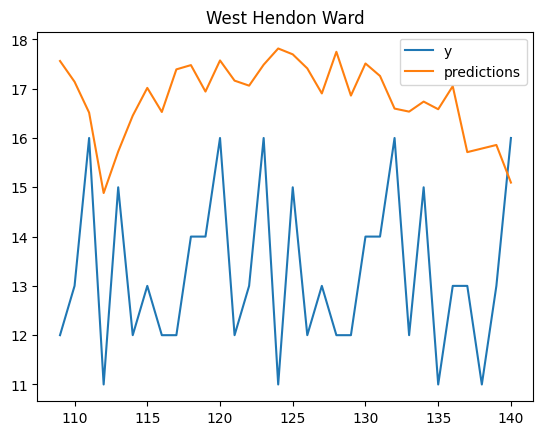

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    13.069836
110    13.488818
111    11.666945
112     4.650811
113    -1.350696
114     1.326291
115     5.725247
116     9.860816
117    10.993237
118    11.684429
119    11.936407
120    11.512476
121    11.172193
122    10.408682
123    10.457495
124    11.499370
125    12.370045
126    12.578131
127    12.909712
128    11.648290
129    12.351897
130    11.391944
131    11.116564
132    11.546961
133    11.381254
134    10.466371
135    10.082196
136     9.113220
137    10.057168
138     9.614518
139     8.602464
140     9.211461
dtype: float64


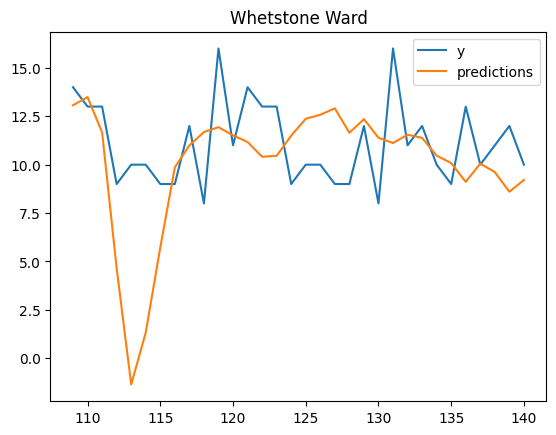

C:\Users\20210777\AppData\Local\Temp\ipykernel_13340\6423242.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions'] = predictions


109    16.341243
110    16.594092
111    14.332409
112     4.557844
113    -4.011104
114    -0.067558
115     6.268451
116    11.228063
117    12.830529
118    13.570751
119    13.825265
120    13.042459
121    12.956087
122    11.277282
123    11.998096
124    13.933275
125    15.187662
126    15.901994
127    15.836118
128    15.253876
129    16.002960
130    15.649052
131    15.983608
132    16.890118
133    16.366026
134    15.933174
135    16.450698
136    16.535593
137    17.730323
138    17.087359
139    16.475609
140    17.415292
dtype: float64


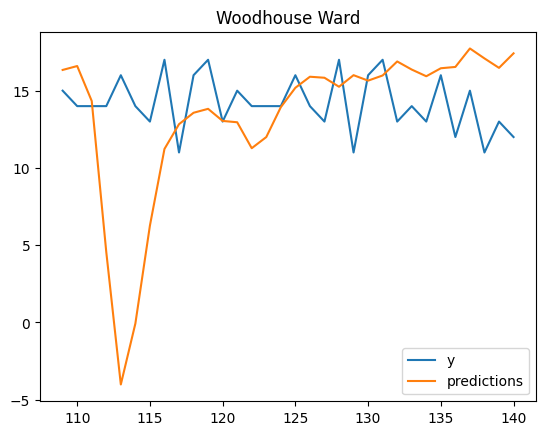

In [42]:
# Initialize lists to store scores
scores_with = []
scores_without = []

for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')
    merg.dropna(inplace=True)

    train_set = merg[merg['ds'] < '2020-01-01']
    train_set.set_index('ds')
    test_set = merg[merg['ds'] >= '2020-01-01']
    test_set.set_index('ds')

    # Linear regression on y
    X_train = train_set[['Unemployment', 'UnemploymentChange', 'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y_train = train_set['trend']
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    score_with = model.rsquared
    scores_with.append(score_with)


    X_test = test_set[['Unemployment', 'UnemploymentChange', 'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    X_test.dropna()
    X_test = sm.add_constant(X_test)
    predictions = model.predict(X_test)
    # print(X_test)
    print(predictions)
    test_set['predictions'] = predictions
    # Plot the predictions
    test_set.plot(y=['y', 'predictions'], title=group)
    plt.show()

In [13]:
crime[crime["Ward"] == "West Hendon Ward"]

,Ward,y
ds,,
2010-12-01,West Hendon Ward,17
2011-01-01,West Hendon Ward,17
2011-02-01,West Hendon Ward,17
2011-03-01,West Hendon Ward,14
2011-04-01,West Hendon Ward,16
...,...,...
2019-08-01,West Hendon Ward,18
2019-09-01,West Hendon Ward,10
2019-10-01,West Hendon Ward,17


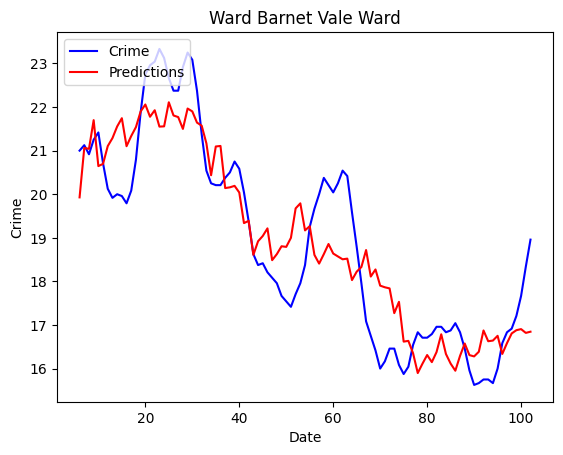

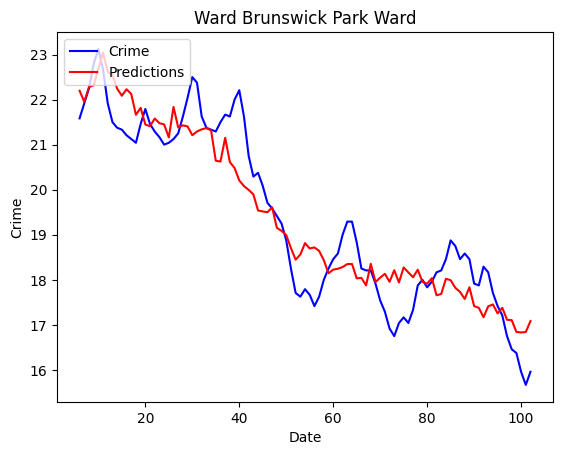

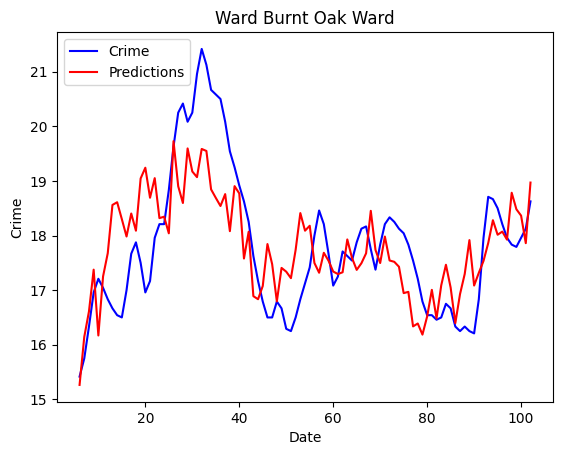

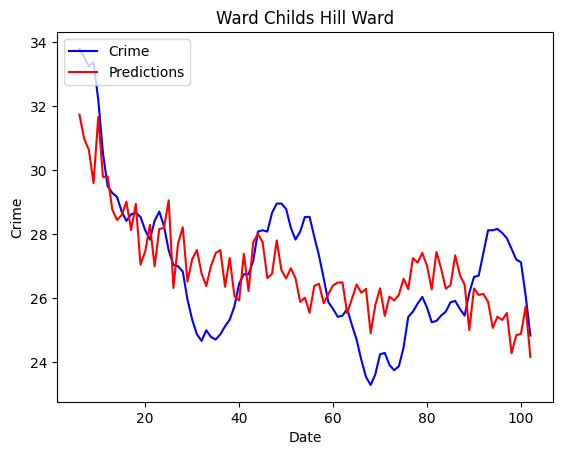

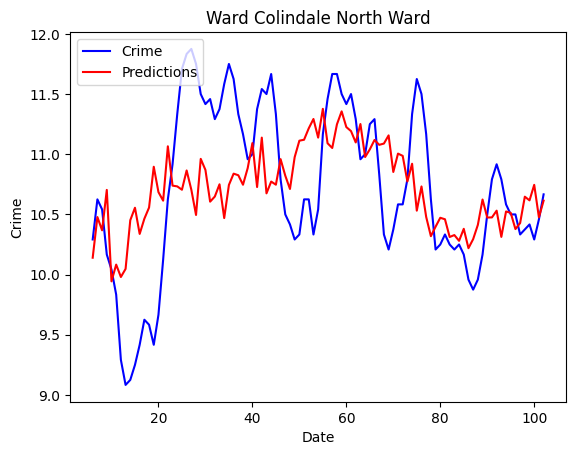

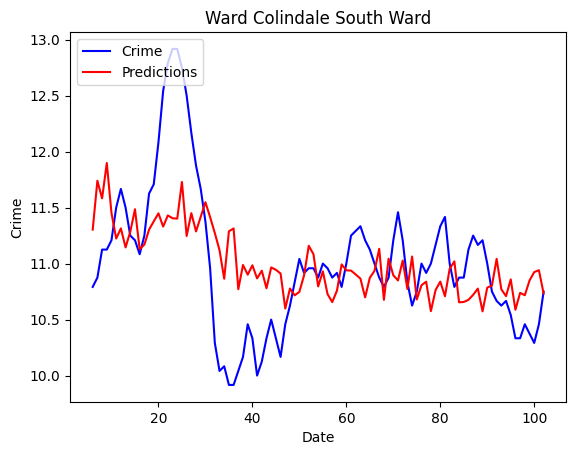

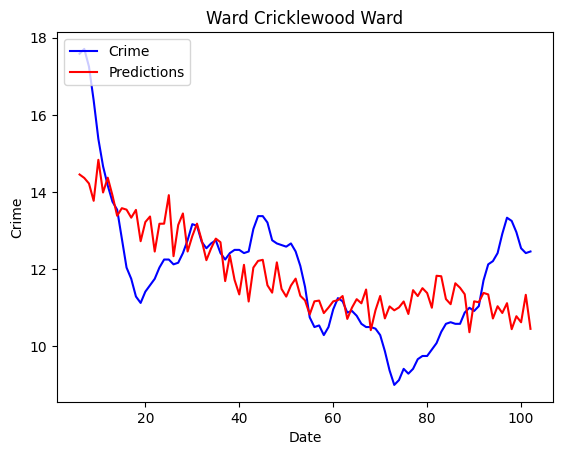

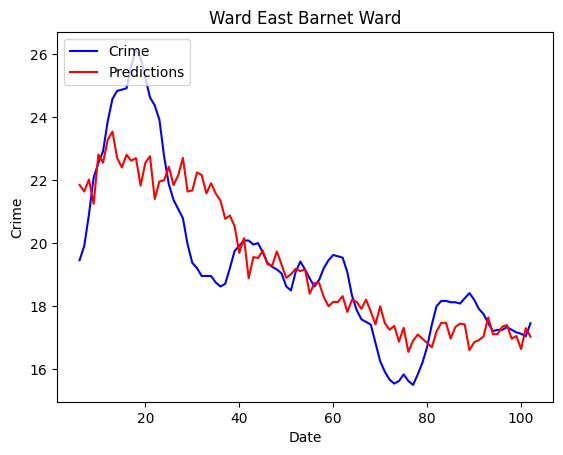

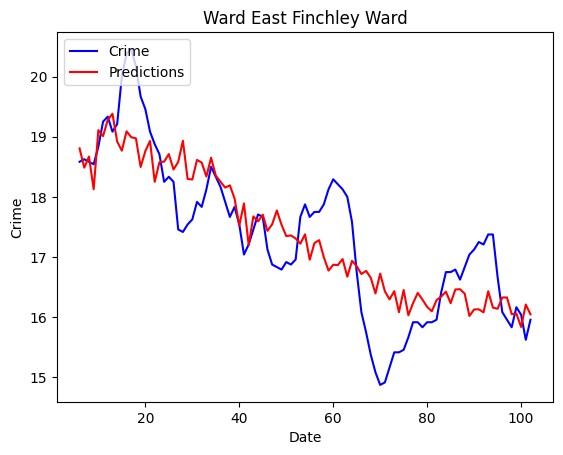

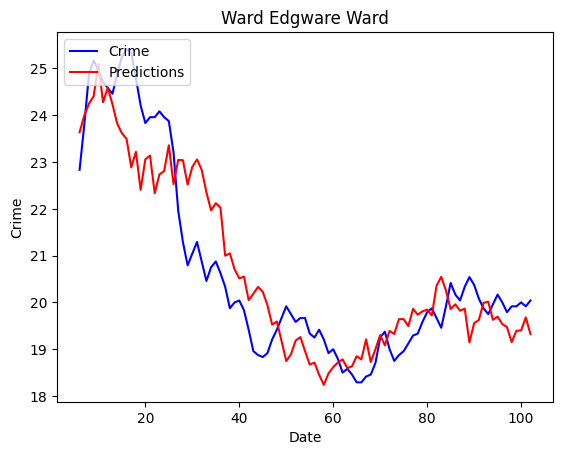

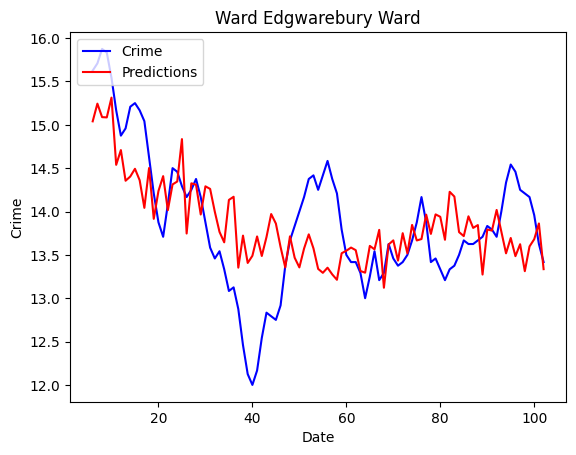

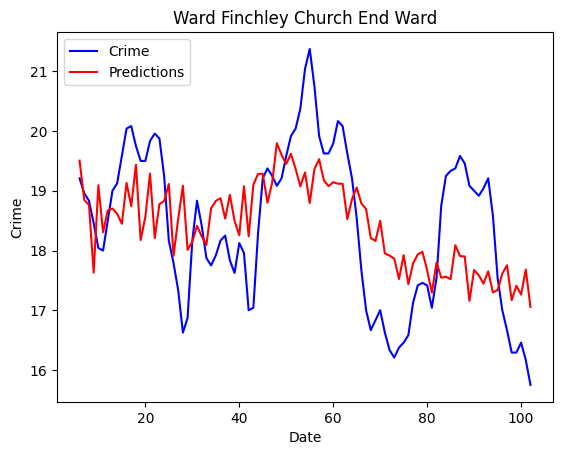

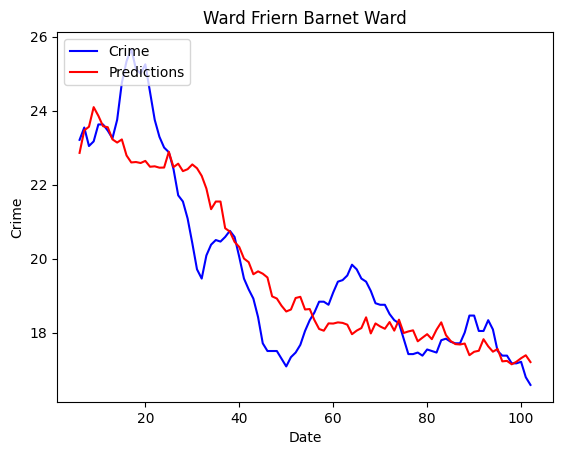

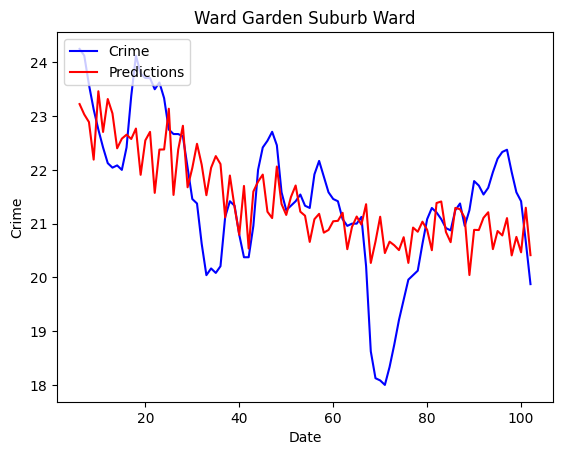

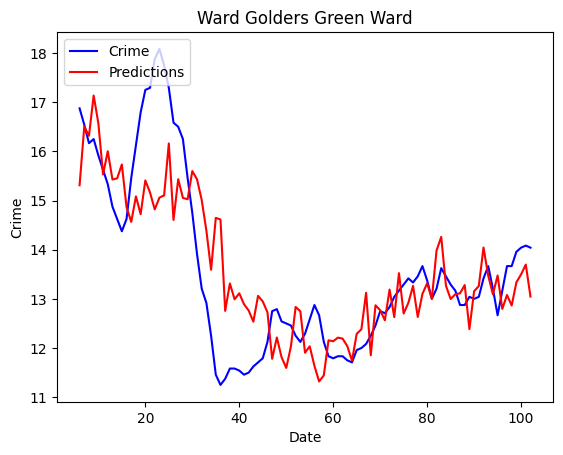

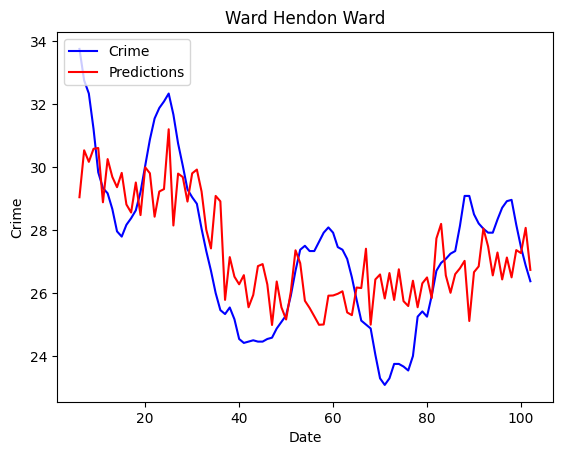

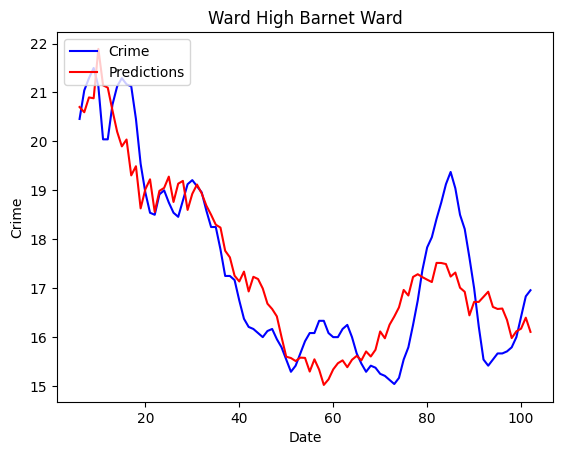

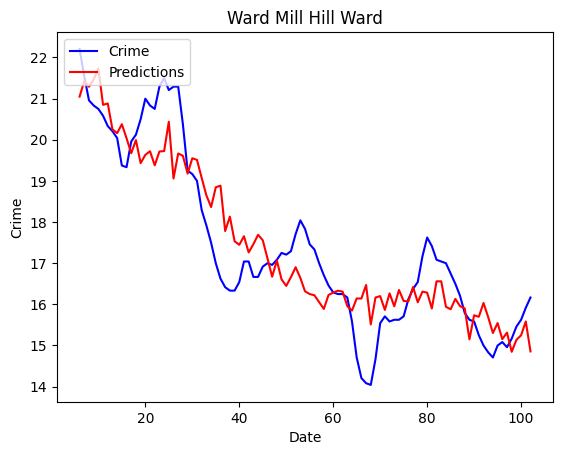

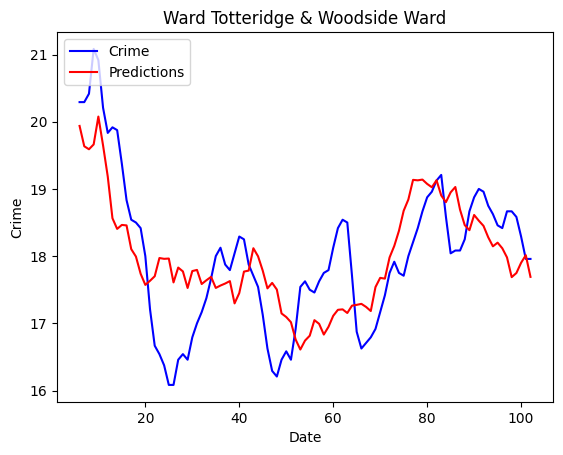

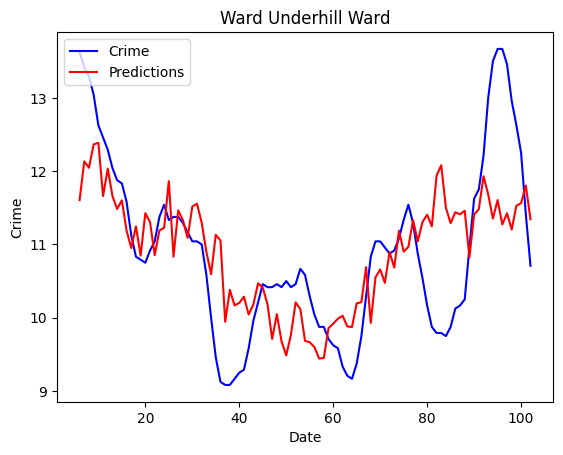

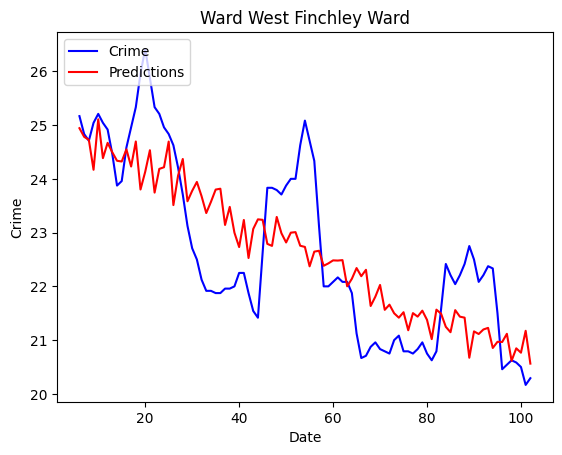

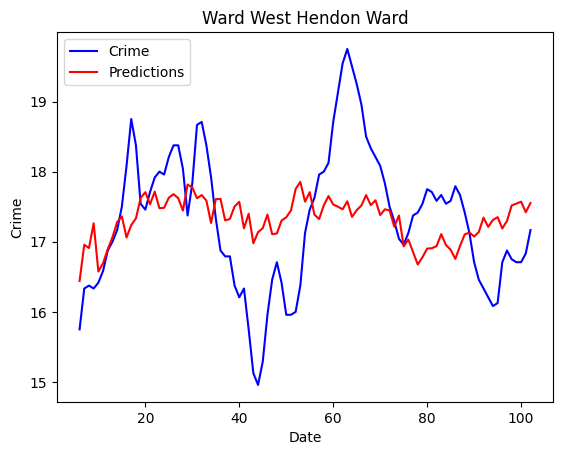

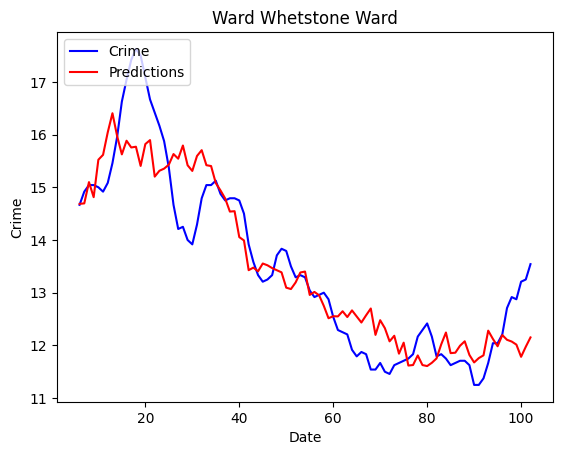

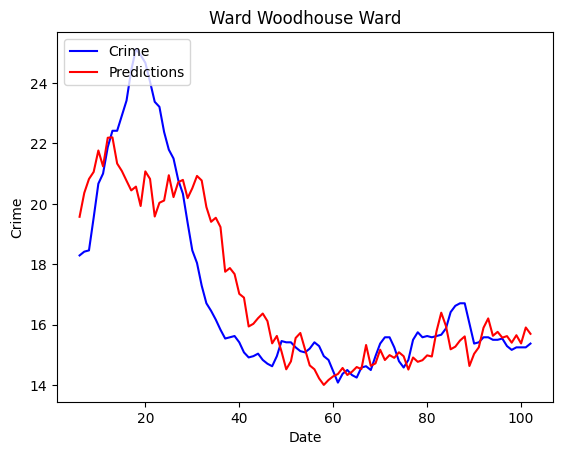

In [27]:

for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')

    merg.set_index('ds')
    merg.dropna(inplace=True)
    # Linear regression on y
    X = merg[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = merg['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    merg['predictions'] = predictions
    # plot the crime data and predictions
    fig, ax = plt.subplots()
    ax.plot(merg['trend'], color='blue', label='Crime')
    ax.plot(merg['predictions'], color='red', label='Predictions')
    ax.set_xlabel('Date')
    ax.set_ylabel('Crime')
    ax.legend(loc='upper left')
    plt.title('Ward ' + str(group))
    plt.show()

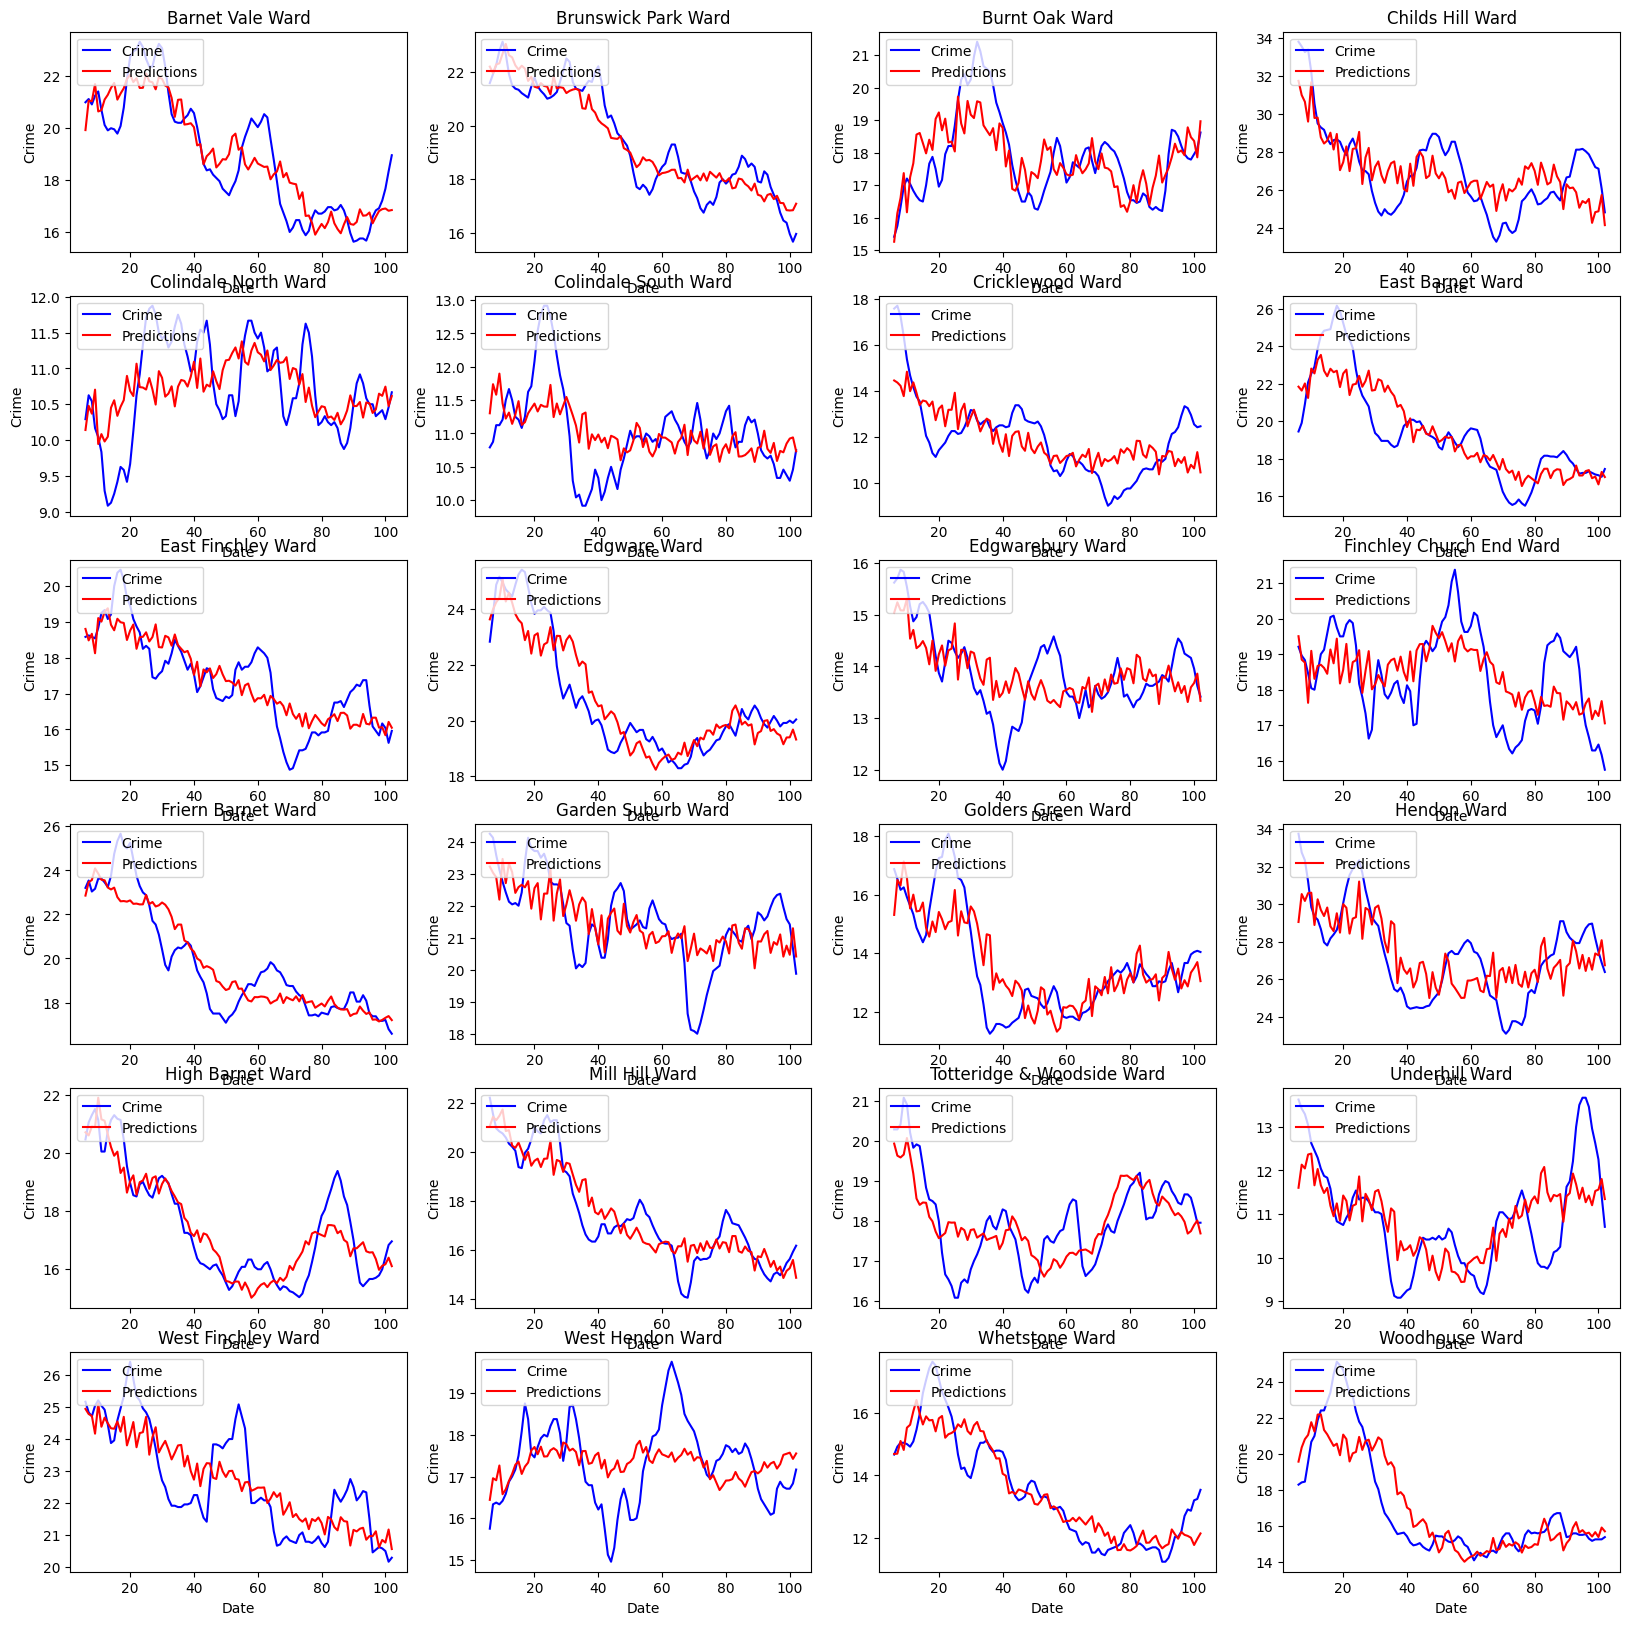

In [29]:
# plot the crime data and predictions on a 6x4 grid
fig, axs = plt.subplots(6, 4, figsize=(20, 20))
count = 1
for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')

    merg.set_index('ds')
    merg.dropna(inplace=True)
    # Linear regression on y
    X = merg[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = merg['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    merg['predictions'] = predictions
    # plot the crime data and predictions
    ax = axs[(count-1)//4, (count-1)%4]
    ax.plot(merg['trend'], color='blue', label='Crime')
    ax.plot(merg['predictions'], color='red', label='Predictions')
    ax.set_xlabel('Date')
    ax.set_ylabel('Crime')
    ax.legend(loc='upper left')
    ax.set_title(str(group))
    count += 1
plt.show()